### Training an object detector from scratch in PyTorch
#### Link: https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/

In [1]:
import torch
import os

from torch.utils.data import Dataset

from torch.nn import Dropout
from torch.nn import Identity
from torch.nn import Linear
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid

from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import Adam
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import time
import cv2
import os



import mimetypes
import argparse
import imutils
import pickle

In [2]:
### Config ###

# path to the input dataset from which we derive the images and annotation files
BASE_PATH = "/home/irikos/Work/datasets/"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])

BASE_OUTPUT = "output"

# define the path to the output model, label encoder, plots output directory and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.pth"])
LE_PATH = os.path.sep.join([BASE_OUTPUT, "le.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [31]:
### HYPERPARAMETERS ###

# determine the current device and based on that set the pin memory
# flag
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

# specify ImageNet mean and standard deviation
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 32

# specify the loss weights
LABELS = 1.0
BBOX = 1.0

In [4]:
### CUSTOM TENSOR DATASET ###
class CustomTensorDataset(Dataset):
    def __init__(self, tensors, transforms=None):
        self.tensors = tensors
        self.transforms = transforms
        
    def __getitem__(self, index):
        # grab the image, label and its bbox coordinates
        image = self.tensors[0][index]
        label = self.tensors[1][index]
        bbox = self.tensors[2][index]
        
        # transpose the image such that its channel dimensions becomes the leading one
        # PyTorch requirements. Basically move from Height x Width x Channels to
        # Channels x Height x Width
        image = image.permute(2, 0, 1)
        
        # check to see if we have any image transformations to apply and, if so, apply them
        if self.transforms:
            image = self.transforms(image)
            
        # return a tuble of images, labels and bounding box coordinates
        return (image, label, bbox)
    
    def __len__(self):
        # return the size of the dataset
        return len(self.tensors[0])

In [5]:
### BBOX REGRESSOR ###
class ObjectDetector(Module):
    def __init__(self, baseModel, numClasses):
        super(ObjectDetector, self).__init__()
        
        # initialize the base model and the number of classes
        self.baseModel = baseModel
        self.numClasses = numClasses
        
        # build the regressor head for outputting the bounding box coordinates
        self.regressor = Sequential(
            Linear(baseModel.fc.in_features, 128),
            ReLU(),
            Linear(128, 64),
            ReLU(),
            Linear(64, 32),
            ReLU(),
            Linear(32, 4),
            Sigmoid()
        )
        
        # build the classifier head to predict the class labels
        self.classifier = Sequential(
            Linear(baseModel.fc.in_features, 512),
            ReLU(),
            Dropout(),
            Linear(512, 512),
            ReLU(),
            Dropout(),
            Linear(512, self.numClasses)
        )
    
        # set the classifier of our base model to produce outputs from the last convolution block
        self.baseModel.fc = Identity()
        
    def forward(self, X):
        # pass the inputs through the base model and then obtain predictions
        # from two different branches of the network
        features = self.baseModel(X)
        bboxes = self.regressor(features)
        classLogits = self.classifier(features)
        
        # return the outputs as a tuple
        return (bboxes, classLogits)
    
    

In [6]:
### TRAINING ###

# initialize the list of data (images), class labels, target bounding box coordinates and image paths
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

for csvPath in paths.list_files(ANNOTS_PATH, validExts=(".txt")):
    rows = open(csvPath).read().strip().split("\n")
    
    # loop over the rows
    for row in rows:
        # break fow into filename, bbox coords and class label
        row = row.split(",")
        (filename, startX, startY, endX, endY, label) = row
        
        # derive the path to the input image, load the image (in openCV format) and grab its dimensions
        imagePath = os.path.sep.join([IMAGES_PATH, filename])
        
        image = cv2.imread(imagePath)
        (h, w) = image.shape[:2]
        
        # scale the bbox coords relative to the spatial dim for the input image
        
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h
        
        # load the image and preprocess it
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        
        # update our lists of data, class labels, bboxes and image paths
        data.append(image)
        labels.append(label)
        bboxes.append((startX, startY, endX, endY))
        imagePaths.append(imagePath)

[INFO] loading dataset...


In [7]:
data = np.array(data, dtype="float32")
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)

# perform label encoding on the labels
le = LabelEncoder()
labels = le.fit_transform(labels)

In [8]:
# partition the data into training and testing splits using 80% - 20%
split = train_test_split(data, labels, bboxes, imagePaths, test_size=0.2, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [9]:
# convert NumPy arrays to PyTorch tensors
(trainImages, testImages) = torch.tensor(trainImages), torch.tensor(testImages)
(trainLabels, testLabels) = torch.tensor(trainLabels), torch.tensor(testLabels)
(trainBBoxes, testBBoxes) = torch.tensor(trainBBoxes), torch.tensor(testBBoxes)

# define normalization transforms
transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [45]:
# convert NumPy arrays to PyTorch datasets
trainDS = CustomTensorDataset((trainImages, trainLabels, trainBBoxes), transforms=transforms)
testDS = CustomTensorDataset((testImages, testLabels, testBBoxes), transforms=transforms)
print("[INFO] total training samples: {}...".format(len(trainDS)))
print("[INFO] total test samples: {}...".format(len(testDS)))

# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(testDS) // BATCH_SIZE

# create data loaders
trainLoader = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), 
                         pin_memory=PIN_MEMORY)

testLoader = DataLoader(testDS, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), 
                         pin_memory=PIN_MEMORY)

[INFO] total training samples: 1394...
[INFO] total test samples: 349...


In [11]:
# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()

[INFO] saving testing image paths...


In [12]:
# load the ResNet50 network as a base netowrk
resnet = resnet50(pretrained=True)

# freeze all ResNet50 layers so they will not be updated during the training process
for params in resnet.parameters():
    params.requires_grad = False

/home/irikos/anaconda3/envs/yolov5/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/irikos/anaconda3/envs/yolov5/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# create or custom object detector model and flash it to the current device
objectDetector = ObjectDetector(resnet, len(le.classes_))
objectDetector = objectDetector.to(DEVICE)

# define our loss functions
classLossFunc = CrossEntropyLoss()
bboxLossFunc = MSELoss()

# initialize the optimizer, compile the model and show the model summary
opt = Adam(objectDetector.parameters(), lr=INIT_LR)
print(objectDetector)

# initialize a dictionary to store training history
H = {"total_train_loss": [], "total_val_loss": [], "train_class_acc": [], "val_class_acc": []}

ObjectDetector(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [47]:
# loop over epochs
print("[INFO] training the network...")

startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    objectDetector.train()
    
    # initialize the total trainign and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    
    # initialize the number of correct predictions in the training and validation step
    trainCorrect = 0
    valCorrect = 0
    
    for (images, labels, bboxes) in trainLoader:
        (images, labels, bboxes) = (images.to(DEVICE), labels.to(DEVICE), bboxes.to(DEVICE))
        
        # perform a forward pass and calculate the training loss
        predictions = objectDetector(images)
        bboxLoss = bboxLossFunc(predictions[0], bboxes)
        classLoss = classLossFunc(predictions[1], labels)
        totalLoss = (BBOX * bboxLoss) + (LABELS * classLoss)
        
        # zero out the gradients, peform the backpropagation step and upgrade the weights
        opt.zero_grad()
        totalLoss.backward()
        opt.step()
        
        # add the loss to the total training loss so far and calcul;ate the number of correct predictions
        totalTrainLoss += totalLoss
        trainCorrect += (predictions[1].argmax(1) == labels).type(torch.float).sum().item()
        
    # switch off autograd
    with torch.no_grad():
        objectDetector.eval()

        # loop over the validatoon set

        for (images, labels, bboxes) in testLoader:
            (images, labels, bboxes) = (images.to(DEVICE), labels.to(DEVICE), bboxes.to(DEVICE))
            
            # make predictions and calculate the validation loss
            predictions = objectDetector(images)
            bboxLoss = bboxLossFunc(predictions[0], bboxes)
            classLoss = classLossFunc(predictions[1], labels)
            
            totalLoss = (BBOX * bboxLoss) + (LABELS * classLoss)
            totalValLoss += totalLoss
            # calculate the number of correct predictions
            valCorrect += (predictions[1].argmax(1) == labels).type(torch.float).sum().item()

    # calculate tthe average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    
    # calculate the training and vaalidation accuracy
    trainCorrect = trainCorrect / len(trainDS)
    valCorrect = valCorrect / len(testDS)
    
    # update our training history
    H["total_train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_class_acc"].append(trainCorrect)
    H["total_val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_class_acc"].append(valCorrect)
    
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(avgValLoss, valCorrect))
    endTime = time.time()
    print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
    

[INFO] training the network...


  5%|█████                                                                                               | 1/20 [00:03<01:02,  3.29s/it]

[INFO] EPOCH: 1/20
Train loss: 0.008924, Train accuracy: 1.0000
Val loss: 0.008989, Val accuracy: 1.0000
[INFO] total time taken to train the model: 3.30s


 10%|██████████                                                                                          | 2/20 [00:06<01:02,  3.47s/it]

[INFO] EPOCH: 2/20
Train loss: 0.008643, Train accuracy: 1.0000
Val loss: 0.008857, Val accuracy: 1.0000
[INFO] total time taken to train the model: 6.90s


 15%|███████████████                                                                                     | 3/20 [00:10<00:57,  3.38s/it]

[INFO] EPOCH: 3/20
Train loss: 0.008528, Train accuracy: 1.0000
Val loss: 0.008732, Val accuracy: 1.0000
[INFO] total time taken to train the model: 10.17s


 20%|████████████████████                                                                                | 4/20 [00:13<00:53,  3.32s/it]

[INFO] EPOCH: 4/20
Train loss: 0.008319, Train accuracy: 1.0000
Val loss: 0.008571, Val accuracy: 1.0000
[INFO] total time taken to train the model: 13.40s


 25%|█████████████████████████                                                                           | 5/20 [00:16<00:49,  3.29s/it]

[INFO] EPOCH: 5/20
Train loss: 0.008155, Train accuracy: 1.0000
Val loss: 0.008468, Val accuracy: 1.0000
[INFO] total time taken to train the model: 16.63s


 30%|██████████████████████████████                                                                      | 6/20 [00:19<00:45,  3.28s/it]

[INFO] EPOCH: 6/20
Train loss: 0.007996, Train accuracy: 1.0000
Val loss: 0.008377, Val accuracy: 1.0000
[INFO] total time taken to train the model: 19.89s


 35%|███████████████████████████████████                                                                 | 7/20 [00:24<00:46,  3.55s/it]

[INFO] EPOCH: 7/20
Train loss: 0.007935, Train accuracy: 1.0000
Val loss: 0.008328, Val accuracy: 1.0000
[INFO] total time taken to train the model: 24.00s


 40%|████████████████████████████████████████                                                            | 8/20 [00:27<00:41,  3.46s/it]

[INFO] EPOCH: 8/20
Train loss: 0.007771, Train accuracy: 1.0000
Val loss: 0.008207, Val accuracy: 1.0000
[INFO] total time taken to train the model: 27.26s


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:30<00:37,  3.39s/it]

[INFO] EPOCH: 9/20
Train loss: 0.007663, Train accuracy: 1.0000
Val loss: 0.008133, Val accuracy: 1.0000
[INFO] total time taken to train the model: 30.49s


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:33<00:33,  3.34s/it]

[INFO] EPOCH: 10/20
Train loss: 0.007598, Train accuracy: 1.0000
Val loss: 0.008061, Val accuracy: 1.0000
[INFO] total time taken to train the model: 33.73s


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:37<00:29,  3.33s/it]

[INFO] EPOCH: 11/20
Train loss: 0.007422, Train accuracy: 1.0000
Val loss: 0.007997, Val accuracy: 1.0000
[INFO] total time taken to train the model: 37.02s


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:40<00:26,  3.29s/it]

[INFO] EPOCH: 12/20
Train loss: 0.007368, Train accuracy: 1.0000
Val loss: 0.008017, Val accuracy: 1.0000
[INFO] total time taken to train the model: 40.23s


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:43<00:22,  3.27s/it]

[INFO] EPOCH: 13/20
Train loss: 0.007341, Train accuracy: 1.0000
Val loss: 0.007955, Val accuracy: 1.0000
[INFO] total time taken to train the model: 43.46s


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [00:46<00:19,  3.26s/it]

[INFO] EPOCH: 14/20
Train loss: 0.007216, Train accuracy: 1.0000
Val loss: 0.008112, Val accuracy: 1.0000
[INFO] total time taken to train the model: 46.70s


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [00:50<00:16,  3.28s/it]

[INFO] EPOCH: 15/20
Train loss: 0.007179, Train accuracy: 1.0000
Val loss: 0.007823, Val accuracy: 1.0000
[INFO] total time taken to train the model: 50.02s


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [00:53<00:13,  3.27s/it]

[INFO] EPOCH: 16/20
Train loss: 0.007010, Train accuracy: 1.0000
Val loss: 0.007869, Val accuracy: 1.0000
[INFO] total time taken to train the model: 53.28s


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [00:56<00:09,  3.30s/it]

[INFO] EPOCH: 17/20
Train loss: 0.006974, Train accuracy: 1.0000
Val loss: 0.007850, Val accuracy: 1.0000
[INFO] total time taken to train the model: 56.66s


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:00<00:06,  3.44s/it]

[INFO] EPOCH: 18/20
Train loss: 0.006902, Train accuracy: 1.0000
Val loss: 0.007686, Val accuracy: 1.0000
[INFO] total time taken to train the model: 60.39s


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:03<00:03,  3.39s/it]

[INFO] EPOCH: 19/20
Train loss: 0.006838, Train accuracy: 1.0000
Val loss: 0.008081, Val accuracy: 1.0000
[INFO] total time taken to train the model: 63.67s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:06<00:00,  3.35s/it]

[INFO] EPOCH: 20/20
Train loss: 0.006955, Train accuracy: 1.0000
Val loss: 0.007735, Val accuracy: 1.0000
[INFO] total time taken to train the model: 66.97s


[INFO] saving object detector model...
[INFO] saving label encoder...


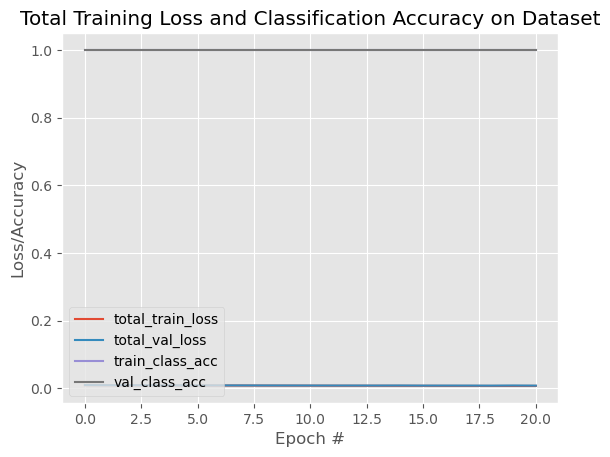

In [51]:
# serialize the model to disk
print("[INFO] saving object detector model...")
torch.save(objectDetector, MODEL_PATH)
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(LE_PATH, "wb")
f.write(pickle.dumps(le))
f.close()
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["total_train_loss"], label="total_train_loss")
plt.plot(H["total_val_loss"], label="total_val_loss")
plt.plot(H["train_class_acc"], label="train_class_acc")
plt.plot(H["val_class_acc"], label="val_class_acc")
plt.title("Total Training Loss and Classification Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# save the training plot
plotPath = os.path.sep.join([PLOTS_PATH, "training.png"])
plt.savefig(plotPath)

In [54]:
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--input", required=True, help="path to input image/text file of image paths")
args = vars(ap.parse_args())

usage: ipykernel_launcher.py [-h] -i INPUT
ipykernel_launcher.py: error: the following arguments are required: -i/--input


SystemExit: 2